<a href="https://colab.research.google.com/github/jorgemarcoes/R-Clustering/blob/main/improveDTW/Tadpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install aeon

In [2]:
import numpy as np
import time
from scipy.cluster.hierarchy import linkage, fcluster
from aeon.datasets import load_classification

from scipy.signal import resample

from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

import pandas as pd
from matplotlib import pyplot as plt


## Install R extensions

In [3]:
%load_ext rpy2.ipython

In [ ]:
#This may take about 10-15 minutes in Google Colab
%%R
install.packages("dtwclust")
library(dtwclust)


#Example of clustering with TADPole algoritmh:

In [6]:
# Load UCR dataset called Trace dataset with aeon library
X, y, meta_data = load_classification("Trace")
print(" Shape of X = ", X.shape)
print(" Meta data = ", meta_data)
data = np.squeeze(X)

# Pass data to R
%R -i data

# Execute clustering
%R result <- tadpole(data,window.size = 30,dc=1,k=4) #Trace Dataset has 4 classes

%R print(result)

 Shape of X =  (200, 1, 275)
 Meta data =  {'problemname': 'trace', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4']}
$cl
  [1] 4 1 2 2 4 3 3 4 4 3 2 2 2 2 2 4 2 1 2 2 3 3 2 1 4 1 2 3 1 3 4 4 2 3 1 4 4
 [38] 1 4 4 2 2 2 2 2 4 2 2 3 1 2 2 1 4 2 1 1 1 1 4 2 1 2 2 2 1 1 4 2 2 1 2 1 4
 [75] 2 3 4 4 2 2 4 2 4 2 2 2 3 4 1 4 2 2 2 4 2 4 1 3 4 1 2 4 2 1 4 2 1 1 1 3 2
[112] 1 2 2 2 2 1 2 4 4 2 2 2 4 1 2 2 2 2 2 2 1 1 1 4 3 2 4 1 3 2 3 1 1 3 1 4 2
[149] 2 2 1 2 1 4 2 4 2 4 2 2 2 4 2 1 3 4 1 4 1 4 4 1 2 2 4 1 1 2 2 1 1 4 3 4 1
[186] 1 2 4 4 4 2 4 4 1 2 2 1 1 2 3

$centroids
[1] 35 44 49 90

$distCalcPercentage
[1] 13.35176



cl,[RTYPES.INTSXP]
centroids,[RTYPES.INTSXP]
distCalcPercentage,[RTYPES.REALSXP]


## Warping Functions

In [7]:
def add_warping(T, p):
    """
    Add warping to a time series T.

    Parameters:
    - T: The original time series with shape (Y,)
    - p: Fraction of points to be removed

    Returns:
    - warped_T: The warped time series
    """

    # Generate random indices
    i = np.random.permutation(len(T))

    # Sort and take only a fraction (1-p) of the indices
    i = np.sort(i[:int((1-p)*len(T))])

    # Resample the time series based on the selected indices
    warped = resample(T[i], len(T))

    # Smooth the resampled time series (optional and can be adjusted)
    warped_smooth = np.convolve(warped, np.ones((2,))/2, mode='same')

    return warped_smooth


def generate_warped_dataset_and_PUA(D, M, add_random_warping):
    """
    Generate a warped dataset and the corresponding pseudo user annotations (PUA).

    Parameters:
    - D: Original dataset with shape (num_instances, time_series_length).
    - M: Amount of warping to add (proportion of points to be removed).
    - add_random_warping: A function that takes in a time series and the warping amount M and returns a warped time series.

    Returns:
    - Dnew: Warped dataset of same shape as D.
    - PUA: Pseudo user annotations, a list of tuples where each tuple contains indices of two time series that must be linked together.
    """

    # Step 1: Arbitrarily shuffle the dataset to ensure it's not ordered in any specific way
    shuffled_indices = np.random.permutation(D.shape[0])
    Dnew = D[shuffled_indices]

    # List to hold our pseudo user annotations
    PUA = []

    # Step 2: For every second data object, replace it with a warped version of the previous data object
    for i in range(0, Dnew.shape[0] - 1, 2): # Loop through every even-indexed time series in steps of 2
        Dnew[i+1] = add_random_warping(Dnew[i], M)

        # Step 3: Annotate the two time series (the original and its warped version) as 'must-link'
        PUA.append((i, i+1))

    # Step 4 & 5: The function returns the new dataset Dnew (of same size as D) and the set of pseudo annotations PUA
    return Dnew, PUA

def evaluate_constraints(clustering_labels, PUA):
    """
    Evaluate the proportion of constraints satisfied by the given clustering.

    This function checks how many of the provided pair constraints (PUA)
    have both data points in the same cluster, based on the given clustering labels.

    Parameters:
    - clustering_labels (list or array-like): Labels assigned to each data point after clustering.
    - PUA (list of tuples): List of data point pairs that should be in the same cluster.
                            Each tuple represents a 'must-link' constraint.

    Returns:
    - float: Proportion of 'must-link' constraints (from PUA) that are satisfied
             by the given clustering. The value ranges between 0 (no constraints satisfied)
             to 1 (all constraints satisfied).

    Example:
    If clustering_labels = [0, 1, 1, 2] and PUA = [(0,1), (1,2)], the return value is 0.5
    because only the pair (1,2) is in the same cluster.
    """

    # Initialize a counter for satisfied constraints
    satisfied = 0

    # Iterate over each pair in PUA
    for (i, j) in PUA:
        # If the two data points in the pair have the same cluster label
        if clustering_labels[i] == clustering_labels[j]:
            # Increment the satisfied counter
            satisfied += 1

    # Return the proportion of satisfied constraints
    return satisfied / len(PUA)




In [14]:
#I get 2500 PUAs for the TwoPatterns dataset
X, y, metadata = load_classification('TwoPatterns')
X = X.squeeze()
X_warped,PUA = generate_warped_dataset_and_PUA(X,0.3,add_warping)
len(PUA)

2500

### Example of warping on a sinusoidal function

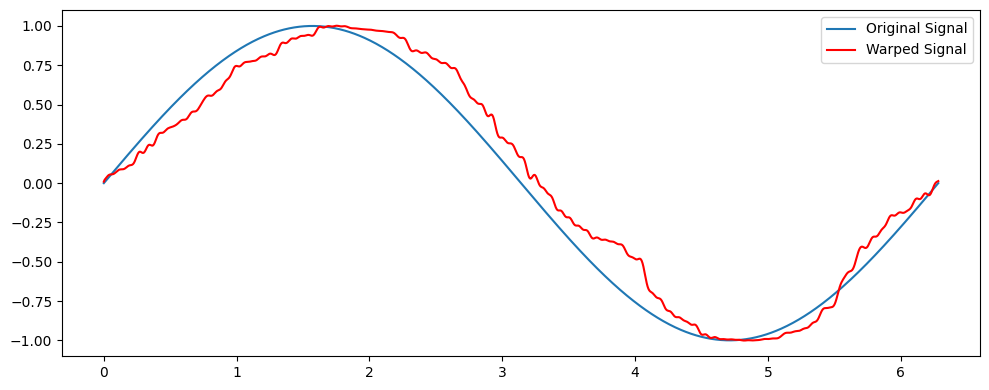

In [9]:
# Generate a sinusoidal signal
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Apply the warping effect
p = 0.8
warped_y = add_warping(y, p)

# Plot the original and warped signals
plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Original Signal")
plt.legend()

plt.plot(x, warped_y, label="Warped Signal", color="red")
plt.legend()

plt.tight_layout()
plt.show()

## Experiments with Trace Dataset

In [ ]:
results = []

#configure the maximum window and step length
max_window = 20
step_len = 1
warping = 0.3

for dataset in ['Trace']: #We'll add a list of datasets later
    # Load the dataset
    X, y, metadata = load_classification(dataset)
    X = X.squeeze()
    %R -i X #pass X variable to R
    n_clusters = len(metadata['class_values'])
    %R -i n_clusters #pass n_clusters to R

    #Generate warped dataset and PUA
    warped_X,PUA = generate_warped_dataset_and_PUA(X,warping, add_warping)
    %R -i warped_X

    print('******* Dataset %s **************' % dataset)


    # Loop windows
    for i in np.arange(1, max_window, step_len):
        window = i
        %R -i window


        ######### Calculate proportion of PUAs satisfied  #############
        # Cluster warped time series
        %R result <- tadpole(warped_X,window.size = window,dc=10,k=n_clusters)
        labels_warped = %R result$cl


        # Calculate proportion satisfied
        prop_satisfied = evaluate_constraints(labels_warped, PUA)

        ######### Evaluate clustering at given window (to compare it with the proportion of PUAs satisfied)  #############
        %R result <- tadpole(X,window.size = window,dc=1,k=4)
        labels_original = %R result$cl

        #calculate ARI and RI:
        ARI = adjusted_rand_score(y,labels_original)
        RI = rand_score(y, labels_original)


        # Append results to the list
        results.append([dataset, window, prop_satisfied, ARI, RI])
        # Print window with 4 decimal places and proportion satisfied
        print('Window: %.3f, Proportion satisfied: %.2f, ARI: %.3f, RI:%.3f' % (window, prop_satisfied, ARI, RI))

    # Convert results to a dataframe
    results_prop = pd.DataFrame(results, columns=['dataset', 'window', 'prop_satisfied', 'ARI', 'RI'])

    path='/content/drive/MyDrive/Doctorado/conv-23/Search optimal w for DTW/'
    # Save results to a csv file. overwrite if already exists. Include warping in the name of the file:
    results_prop.to_csv(path + 'results_tadpole_warping_%s.csv' % warping, index=False)




******* Dataset Trace **************
Window: 1.000, Proportion satisfied: 0.98, ARI: 0.372, RI:0.749
Window: 2.000, Proportion satisfied: 0.95, ARI: 0.405, RI:0.749
Window: 3.000, Proportion satisfied: 0.98, ARI: 0.412, RI:0.751
Window: 4.000, Proportion satisfied: 0.97, ARI: 0.406, RI:0.751
Window: 5.000, Proportion satisfied: 0.98, ARI: 0.414, RI:0.753
Window: 6.000, Proportion satisfied: 0.92, ARI: 0.495, RI:0.790
Window: 7.000, Proportion satisfied: 0.89, ARI: 0.535, RI:0.806
Window: 8.000, Proportion satisfied: 0.94, ARI: 0.459, RI:0.772
Window: 9.000, Proportion satisfied: 0.94, ARI: 0.464, RI:0.774
Window: 10.000, Proportion satisfied: 0.99, ARI: 0.450, RI:0.768
Window: 11.000, Proportion satisfied: 1.00, ARI: 0.627, RI:0.843
Window: 12.000, Proportion satisfied: 0.95, ARI: 0.627, RI:0.843
Window: 13.000, Proportion satisfied: 0.96, ARI: 0.628, RI:0.844
Window: 14.000, Proportion satisfied: 0.95, ARI: 0.626, RI:0.843
Window: 15.000, Proportion satisfied: 0.85, ARI: 0.626, RI:0.8

## Try different cuttoff distances in the optimal windows for Trace and TwoPatterns

In [16]:
X, y, metadata = load_classification('Trace')
X = X.squeeze()
%R -i X
n_clusters = len(metadata['class_values'])

print('******* TRACE DATASET WITH OPTIMAL WINDOW **************' )


for cutoff in range(1,20):

  print('******* Cutoff distance %s **************' % cutoff)

  %R -i cutoff
  %R result <- TADPole(X,window.size = 7,dc=cutoff,k=4) #We use optimal window of 7 for Trace dataset according to the paper
  labels_original = %R result$cl

  #calculate ARI and RI:
  ARI = adjusted_rand_score(y,labels_original)
  RI = rand_score(y, labels_original)
  print('RI:%.3f' % (RI))


******* TRACE DATASET WITH OPTIMAL WINDOW **************
******* Cutoff distance 1 **************
RI:0.806
******* Cutoff distance 2 **************
RI:0.836
******* Cutoff distance 3 **************
RI:0.753
******* Cutoff distance 4 **************
RI:0.789
******* Cutoff distance 5 **************
RI:0.793
******* Cutoff distance 6 **************
RI:0.770
******* Cutoff distance 7 **************
RI:0.751
******* Cutoff distance 8 **************
RI:0.768
******* Cutoff distance 9 **************
RI:0.750
******* Cutoff distance 10 **************
RI:0.750
******* Cutoff distance 11 **************
RI:0.749
******* Cutoff distance 12 **************
RI:0.768
******* Cutoff distance 13 **************
RI:0.754
******* Cutoff distance 14 **************
RI:0.751
******* Cutoff distance 15 **************
RI:0.754
******* Cutoff distance 16 **************
RI:0.762
******* Cutoff distance 17 **************
RI:0.815
******* Cutoff distance 18 **************
RI:0.750
******* Cutoff distance 19 *******

In [17]:
X, y, metadata = load_classification('TwoPatterns')
X = X.squeeze()
%R -i X
n_clusters = len(metadata['class_values'])
%R -i n_clusters

print('******* TWOPATTERNS DATASET WITH OPTIMAL WINDOW **************' )

for cutoff in range(2,10): #For some values below 5 it returns an error

  print('******* Cutoff distance %s **************' % cutoff)

  %R -i cutoff
  %R result <- TADPole(X,window.size = 8,dc=cutoff,k=n_clusters) #We use optimal window of 8 for TwoPatterns dataset according to the paper
  labels_original = %R result$cl

  #calculate ARI and RI:
  ARI = adjusted_rand_score(y,labels_original)
  RI = rand_score(y, labels_original)
  print('RI:%.3f' % (RI))


******* TWOPATTERNS DATASET WITH OPTIMAL WINDOW **************
******* Cutoff distance 2 **************
RI:0.549
******* Cutoff distance 3 **************
RI:0.735
******* Cutoff distance 4 **************
RI:0.805
******* Cutoff distance 5 **************
RI:0.732
******* Cutoff distance 6 **************
RI:0.772
******* Cutoff distance 7 **************
RI:0.728
******* Cutoff distance 8 **************
RI:0.679
******* Cutoff distance 9 **************
RI:0.650


# Full experiment

In [ ]:
results = []

#configure the maximum window and step length
max_window = 20
step_len = 1
warping = 0.3

for dataset in ['Trace']:
    # Load the dataset
    X, y, metadata = load_classification(dataset)
    X = X.squeeze()
    %R -i X
    n_clusters = len(metadata['class_values'])

    #Generate warped dataset and PUA
    warped_X,PUA = generate_warped_dataset_and_PUA(X,warping, add_warping)
    %R -i warped_X

    print('******* Dataset %s **************' % dataset)


    # Loop windows
    for i in np.arange(1, max_window, step_len):
        window = i
        %R -i window


        ######### Calculate proportion of PUAs satisfied  #############
        # Cluster warped time series
        %R result <- tadpole(warped_X,window.size = window,dc=10,k=4)
        labels_warped = %R result$cl


        # Calculate proportion satisfied
        prop_satisfied = evaluate_constraints(labels_warped, PUA)

        ######### Evaluate clustering at given window (to compare it with the proportion of PUAs satisfied)  #############
        %R result <- tadpole(X,window.size = window,dc=1,k=4)
        labels_original = %R result$cl

        #calculate ARI and RI:
        ARI = adjusted_rand_score(y,labels_original)
        RI = rand_score(y, labels_original)


        # Append results to the list
        results.append([dataset, window, prop_satisfied, ARI, RI])
        # Print window with 4 decimal places and proportion satisfied
        print('Window: %.3f, Proportion satisfied: %.2f, ARI: %.3f, RI:%.3f' % (window, prop_satisfied, ARI, RI))

    # Convert results to a dataframe
    results_prop = pd.DataFrame(results, columns=['dataset', 'window', 'prop_satisfied', 'ARI', 'RI'])

    path='/content/drive/MyDrive/Doctorado/conv-23/Search optimal w for DTW/'
    # Save results to a csv file. overwrite if already exists. Include warping in the name of the file:
    results_prop.to_csv(path + 'results_tadpole_warping_%s.csv' % warping, index=False)


